# 1. Forward Stepwise Selection


In [1]:
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec
from ISLP.models import sklearn_selected
from sklearn.linear_model import LinearRegression

# Load data
local_path = '/Users/anhnguyen/Documents/GitHub/2025AAE722_AnhNguyen/2025 AAE722 Anh Nguyen Submission/ALL CSV FILES - 2nd Edition/Auto.csv'
auto = pd.read_csv(local_path)


# Keep a clean copy; drop the non-predictor "name", drop NA
auto = auto.drop(columns=['name'], errors='ignore').dropna()

# Print the first few rows of the cleaned DataFrame
print(auto.head())



    mpg  cylinders  displacement horsepower  weight  acceleration  year  \
0  18.0          8         307.0        130    3504          12.0    70   
1  15.0          8         350.0        165    3693          11.5    70   
2  18.0          8         318.0        150    3436          11.0    70   
3  16.0          8         304.0        150    3433          12.0    70   
4  17.0          8         302.0        140    3449          10.5    70   

   origin  
0       1  
1       1  
2       1  
3       1  
4       1  


In [2]:
# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Ensure horsepower is numeric and drop any rows that become NA
auto['horsepower'] = pd.to_numeric(auto['horsepower'], errors='coerce')
auto = auto.dropna().reset_index(drop=True)

# Define predictors and response
predictors = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']
X_df = auto[predictors]
y = auto['mpg']
n = len(y)

# Fit the full OLS model to estimate sigma^2 (use sklearn LinearRegression and RSS)
full_model = LinearRegression().fit(X_df, y)
y_pred_full = full_model.predict(X_df)
rss_full = np.sum((y - y_pred_full) ** 2)
p_full = X_df.shape[1] + 1  # number of parameters including intercept
sigma2_hat = rss_full / (n - p_full)  # MSE from full model

# Forward stepwise selection using Mallows' Cp criterion (greedy forward path)
available = predictors.copy()
selected = []
cp_path = []

def compute_rss(X_subset):
    model = LinearRegression().fit(X_subset, y)
    preds = model.predict(X_subset)
    return np.sum((y - preds) ** 2), model

# Start forward selection
prev_cp = None
selection_sequence = []
models_at_step = []

for k in range(1, len(predictors) + 1):
    best_cp = np.inf
    best_var = None
    best_model = None
    best_rss = None

    for var in available:
        candidate = selected + [var]
        X_cand = X_df[candidate]
        rss_k, model_k = compute_rss(X_cand)
        p_k = len(candidate) + 1  # parameters including intercept
        cp_k = (rss_k / sigma2_hat) - (n - 2 * p_k)
        if cp_k < best_cp:
            best_cp = cp_k
            best_var = var
            best_model = model_k
            best_rss = rss_k

    # update selected and available
    selected.append(best_var)
    available.remove(best_var)
    cp_path.append(best_cp)
    selection_sequence.append(selected.copy())
    models_at_step.append((best_model, best_rss))

# Apply "first_peak" style stopping:
# find first index i where cp[i] > cp[i-1], then take model at i-1.
# If never increases, choose the model with minimum Cp along the path.
chosen_index = None
for i in range(1, len(cp_path)):
    if cp_path[i] > cp_path[i - 1]:
        chosen_index = i - 1
        break

if chosen_index is None:
    # take model with minimum Cp
    chosen_index = int(np.argmin(cp_path))

final_selected = selection_sequence[chosen_index]
final_model, final_rss = models_at_step[chosen_index]

# Retrieve coefficients for stepwise-selected model
coef_dict_stepwise = {'intercept': final_model.intercept_}
for name, coef in zip(final_selected, final_model.coef_):
    coef_dict_stepwise[name] = coef

# Retrieve coefficients for full OLS model
coef_dict_full = {'intercept': full_model.intercept_}
for name, coef in zip(predictors, full_model.coef_):
    coef_dict_full[name] = coef

# Report results
print("Stepwise selection (Cp) results:")
print("  Cp path (per step):", np.round(cp_path, 4))
print("  Selection sequence per step:", selection_sequence)
print("  Chosen step index (0-based):", chosen_index)
print("  (a) Variables selected by stepwise selection:", final_selected)
print()
print("  (b) Final OLS coefficients:")
print("    Stepwise-selected model coefficients:")
for k, v in coef_dict_stepwise.items():
    print(f"      {k}: {v:.6f}")
print()
print("    Full model coefficients (all predictors):")
for k, v in coef_dict_full.items():
    print(f"      {k}: {v:.6f}")

Stepwise selection (Cp) results:
  Cp path (per step): [273.1508  26.6035   8.6597   9.2711   7.1273   6.6645   8.    ]
  Selection sequence per step: [['weight'], ['weight', 'year'], ['weight', 'year', 'origin'], ['weight', 'year', 'origin', 'displacement'], ['weight', 'year', 'origin', 'displacement', 'horsepower'], ['weight', 'year', 'origin', 'displacement', 'horsepower', 'cylinders'], ['weight', 'year', 'origin', 'displacement', 'horsepower', 'cylinders', 'acceleration']]
  Chosen step index (0-based): 2
  (a) Variables selected by stepwise selection: ['weight', 'year', 'origin']

  (b) Final OLS coefficients:
    Stepwise-selected model coefficients:
      intercept: -18.045850
      weight: -0.005994
      year: 0.757126
      origin: 1.150391

    Full model coefficients (all predictors):
      intercept: -17.218435
      cylinders: -0.493376
      displacement: 0.019896
      horsepower: -0.016951
      weight: -0.006474
      acceleration: 0.080576
      year: 0.750773
      

# 2. Ridge Regression Analysis

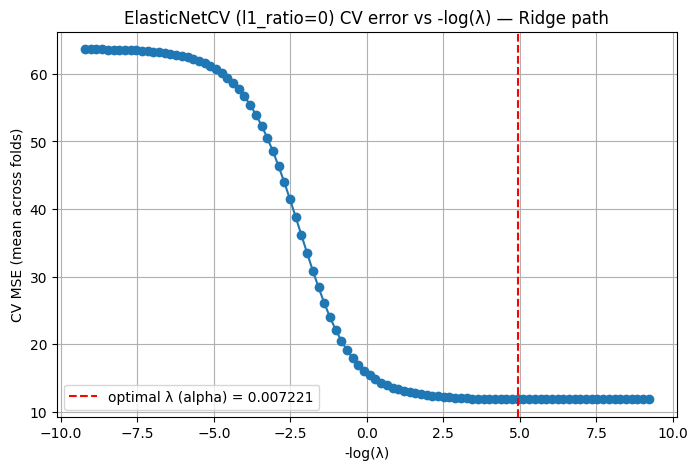

Test MSE (Ridge via ElasticNetCV, alpha=0.00722081): 10.831869
Test MSE (OLS): 10.710864


In [3]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

import matplotlib.pyplot as plt

# Use existing X_df and y from the notebook
X = X_df.copy()
y_series = y.copy()

# Train/test split (fixed random state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y_series, test_size=0.2, random_state=42)

# Define an explicit alpha grid because ElasticNetCV cannot auto-generate alphas when l1_ratio=0
alpha_grid = np.logspace(-4, 4, 100)

# Pipeline: standardization then ElasticNetCV with l1_ratio=0 (ridge), 5-fold CV
# provide alphas=alpha_grid to avoid the ValueError
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge_enetcv", ElasticNetCV(l1_ratio=0, alphas=alpha_grid, cv=5, max_iter=10000, random_state=42))
])

# fit pipeline and extract fitted ElasticNetCV
ridge_pipe.fit(X_train, y_train)
enet = ridge_pipe.named_steps["ridge_enetcv"]

# sanity check
if not hasattr(enet, "alphas_"):
    raise RuntimeError("ElasticNetCV step not fitted; ensure ridge_pipe.fit(...) ran successfully")

# Extract alphas and cross-validated MSE path, robust to shapes:
alphas = enet.alphas_  # array of candidate alphas
mse_path = enet.mse_path_

# mse_path can have shape (n_l1_ratio, n_alphas, n_folds) or (n_alphas, n_folds)
if mse_path.ndim == 3:
    # take first l1_ratio (we used a single l1_ratio=0), then average over folds
    mean_mse_per_alpha = mse_path[0].mean(axis=1)
elif mse_path.ndim == 2:
    mean_mse_per_alpha = mse_path.mean(axis=1)
else:
    raise RuntimeError("Unexpected shape of mse_path_: " + str(mse_path.shape))

# Plot CV error vs -log(alpha) and mark optimal alpha
opt_alpha = enet.alpha_
x_vals = -np.log(alphas)
x_opt = -np.log(opt_alpha)

plt.figure(figsize=(8, 5))
plt.plot(x_vals, mean_mse_per_alpha, marker='o', linestyle='-')
plt.axvline(x_opt, color='red', linestyle='--', label=f"optimal λ (alpha) = {opt_alpha:.4g}")
plt.scatter([x_opt], [np.interp(x_opt, x_vals, mean_mse_per_alpha)], color='red')
plt.xlabel("-log(λ)")
plt.ylabel("CV MSE (mean across folds)")
plt.title("ElasticNetCV (l1_ratio=0) CV error vs -log(λ) — Ridge path")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate test MSE for ridge (pipeline) and OLS (pipeline with same scaler)
# Ridge predictions
y_pred_ridge = ridge_pipe.predict(X_test)
mse_ridge_test = mean_squared_error(y_test, y_pred_ridge)

# OLS pipeline (standardize then LinearRegression for fair comparison)
ols_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ols", LinearRegression())
])
ols_pipe.fit(X_train, y_train)
y_pred_ols = ols_pipe.predict(X_test)
mse_ols_test = mean_squared_error(y_test, y_pred_ols)

print(f"Test MSE (Ridge via ElasticNetCV, alpha={opt_alpha:.6g}): {mse_ridge_test:.6f}")
print(f"Test MSE (OLS): {mse_ols_test:.6f}")

In [4]:
# Brief interpretation comparing ridge vs OLS using existing notebook variables
diff = mse_ridge_test - mse_ols_test
pct = diff / mse_ols_test * 100

print(f"Ridge test MSE: {mse_ridge_test:.6f}")
print(f"OLS  test MSE: {mse_ols_test:.6f}")
print(f"Difference (Ridge - OLS): {diff:.6f} ({pct:.3f}%)")

# Short conclusion
if diff > 0:
    print("Conclusion: Ridge did not improve prediction here; OLS is slightly better on the test set.")
elif diff < 0:
    print("Conclusion: Ridge slightly improved prediction over OLS on the test set.")
else:
    print("Conclusion: Ridge and OLS have identical test MSE.")

# Short rationale
print(f"Rationale: Optimal ridge alpha = {opt_alpha:.6g}. The alpha is small, so coefficients were only lightly shrunk; "
      "with this dataset and predictors the regularization did not reduce test MSE (difference is small).")

Ridge test MSE: 10.831869
OLS  test MSE: 10.710864
Difference (Ridge - OLS): 0.121004 (1.130%)
Conclusion: Ridge did not improve prediction here; OLS is slightly better on the test set.
Rationale: Optimal ridge alpha = 0.00722081. The alpha is small, so coefficients were only lightly shrunk; with this dataset and predictors the regularization did not reduce test MSE (difference is small).


# 3. Lasso Regression


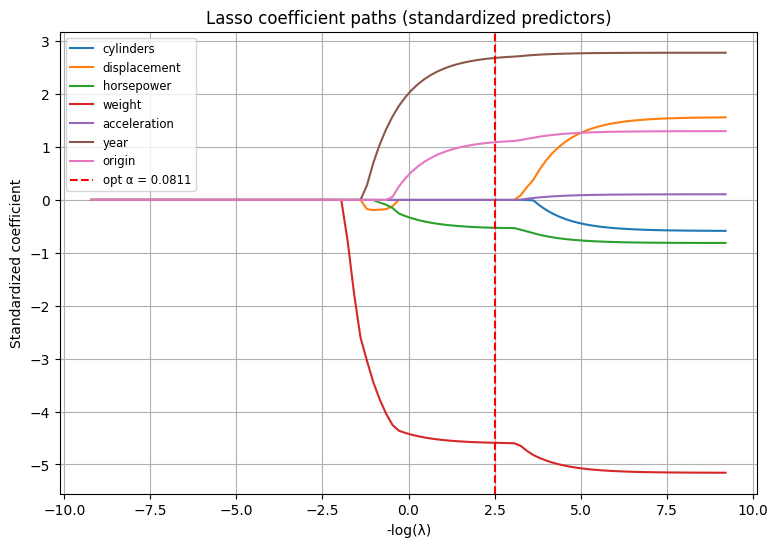

Final Lasso coefficients (standardized scale):
  intercept: 23.599361
  cylinders: -0.000000
  displacement: 0.000000
  horsepower: -0.527216
  weight: -4.590825
  acceleration: 0.000000
  year: 2.683869
  origin: 1.090915

Number of non-zero coefficients (excluding intercept): 4
Test MSE: 10.959014


In [5]:
from sklearn.linear_model import ElasticNetCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

import matplotlib.pyplot as plt

# Fit ElasticNetCV with l1_ratio=1 (Lasso) in a pipeline with standardization
lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso_enetcv", ElasticNetCV(l1_ratio=1, alphas=alpha_grid, cv=5, max_iter=10000, random_state=42))
])
lasso_pipe.fit(X_train, y_train)
enet_lasso = lasso_pipe.named_steps["lasso_enetcv"]
opt_alpha = enet_lasso.alpha_
alphas = enet_lasso.alphas_

# Prepare standardized training data for coefficient path (fit scaler on training set)
scaler = lasso_pipe.named_steps["scaler"]
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute coefficient path by fitting Lasso for each alpha on standardized X_train
coef_path = np.zeros((len(alphas), X_train.shape[1]))
for i, a in enumerate(alphas):
    l = Lasso(alpha=a, max_iter=20000)
    l.fit(X_train_scaled, y_train)
    coef_path[i, :] = l.coef_

# Plot coefficient paths vs -log(alpha)
x_vals = -np.log(alphas)
plt.figure(figsize=(9, 6))
for j, name in enumerate(X_train.columns):
    plt.plot(x_vals, coef_path[:, j], label=name, linewidth=1.5)
plt.axvline(-np.log(opt_alpha), color='red', linestyle='--', label=f"opt α = {opt_alpha:.3g}")
plt.xlabel("-log(λ)")
plt.ylabel("Standardized coefficient")
plt.title("Lasso coefficient paths (standardized predictors)")
plt.legend(loc="best", fontsize="small")
plt.grid(True)
plt.show()

# Final coefficient estimates (from ElasticNetCV fitted inside pipeline)
final_coefs = enet_lasso.coef_
intercept = enet_lasso.intercept_
coef_series = dict(intercept=intercept, **{name: coef for name, coef in zip(X_train.columns, final_coefs)})

# Number of non-zero coefficients and test MSE
n_nonzero = np.count_nonzero(np.abs(final_coefs) > 1e-8)
y_pred_test = lasso_pipe.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)

# Print concise results
print("Final Lasso coefficients (standardized scale):")
for k, v in coef_series.items():
    print(f"  {k}: {v:.6f}")
print(f"\nNumber of non-zero coefficients (excluding intercept): {n_nonzero}")
print(f"Test MSE: {test_mse:.6f}")

In [6]:
# Compare Lasso vs Ridge test MSE (uses variables from previous cells)
lasso_mse = test_mse
ridge_mse = mse_ridge_test
diff = lasso_mse - ridge_mse
pct = diff / ridge_mse * 100

print(f"Lasso test MSE: {lasso_mse:.6f}")
print(f"Ridge test MSE: {ridge_mse:.6f}")
print(f"Difference (Lasso - Ridge): {diff:.6f} ({pct:.3f}%)")
print(f"Lasso non-zero coefficients (excl. intercept): {n_nonzero}")

if diff > 0:
    print("Conclusion: Ridge performs slightly better on the test set (lower MSE).")
elif diff < 0:
    print("Conclusion: Lasso performs slightly better on the test set (lower MSE).")
else:
    print("Conclusion: Lasso and Ridge have identical test MSE.")

Lasso test MSE: 10.959014
Ridge test MSE: 10.831869
Difference (Lasso - Ridge): 0.127146 (1.174%)
Lasso non-zero coefficients (excl. intercept): 4
Conclusion: Ridge performs slightly better on the test set (lower MSE).


# 4. Comprehensive Model Comparison



In [7]:
# Load Boston dataset (uses pandas imported earlier in the notebook)
boston_path = '/Users/anhnguyen/Documents/GitHub/2025AAE722_AnhNguyen/2025 AAE722 Anh Nguyen Submission/ALL CSV FILES - 2nd Edition/Boston.csv'
boston = pd.read_csv(boston_path)

# Drop rows with missing values (if any) and reset index
boston = boston.dropna().reset_index(drop=True)
print("\nAfter dropping NA — shape:", boston.shape)

# Show first few rows
print("\nFirst 5 rows of the dataset:")
print(boston.head())


After dropping NA — shape: (506, 14)

First 5 rows of the dataset:
   Unnamed: 0     crim    zn  indus  chas    nox     rm   age     dis  rad  \
0           1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1   
1           2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2   
2           3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2   
3           4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3   
4           5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3   

   tax  ptratio  lstat  medv  
0  296     15.3   4.98  24.0  
1  242     17.8   9.14  21.6  
2  242     17.8   4.03  34.7  
3  222     18.7   2.94  33.4  
4  222     18.7   5.33  36.2  


In [10]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

#ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


# Choose response column (common names or fallback to last column)
for candidate in ("medv", "MEDV", "target", "y"):
    if candidate in boston.columns:
        y_col = candidate
        break
else:
    y_col = boston.columns[-1]

# Prepare predictors (numeric only) and response, drop NA
boston_clean = boston.dropna().reset_index(drop=True)
X_all = boston_clean.select_dtypes(include=[np.number]).drop(columns=[y_col], errors='ignore')
y_all = boston_clean[y_col]

# Train/test split 70/30 with random_state=77
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.7, random_state=77)

# 1) OLS (standardized for fair comparison)
ols_pipe = Pipeline([("scaler", StandardScaler()), ("ols", LinearRegression())])
ols_pipe.fit(X_train, y_train)
mse_ols = mean_squared_error(y_test, ols_pipe.predict(X_test))

# 2) Forward stepwise selection using Cp (greedy forward path) on training data
n_train = len(y_train)
predictor_names = list(X_train.columns)

# estimate sigma^2 from full OLS fit on training data
full_train = LinearRegression().fit(X_train, y_train)
rss_full_train = np.sum((y_train - full_train.predict(X_train)) ** 2)
p_full = X_train.shape[1] + 1
sigma2_hat_train = rss_full_train / (n_train - p_full)

available = predictor_names.copy()
selected = []
cp_path = []
selection_sequence = []
models_at_step = []

def compute_rss_train(X_sub):
    m = LinearRegression().fit(X_sub, y_train)
    preds = m.predict(X_sub)
    return np.sum((y_train - preds) ** 2), m

for k in range(1, len(predictor_names) + 1):
    best_cp = np.inf
    best_var = None
    best_model = None
    best_rss = None
    for var in available:
        cand = selected + [var]
        X_cand = X_train[cand]
        rss_k, model_k = compute_rss_train(X_cand)
        p_k = len(cand) + 1
        cp_k = (rss_k / sigma2_hat_train) - (n_train - 2 * p_k)
        if cp_k < best_cp:
            best_cp, best_var, best_model, best_rss = cp_k, var, model_k, rss_k
    selected.append(best_var)
    available.remove(best_var)
    cp_path.append(best_cp)
    selection_sequence.append(selected.copy())
    models_at_step.append((best_model, best_rss))

# Stepwise.first_peak() stopping: first i where cp[i] > cp[i-1], choose model at i-1
chosen_index = None
for i in range(1, len(cp_path)):
    if cp_path[i] > cp_path[i-1]:
        chosen_index = i - 1
        break
if chosen_index is None:
    chosen_index = int(np.argmin(cp_path))

stepwise_vars = selection_sequence[chosen_index]
stepwise_model = models_at_step[chosen_index][0]
mse_stepwise = mean_squared_error(y_test, stepwise_model.predict(X_test[stepwise_vars]))

# 3) Ridge (ElasticNetCV with l1_ratio=0) tuned on training data
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge_enetcv", ElasticNetCV(l1_ratio=0, alphas=alpha_grid, cv=5, max_iter=10000, random_state=77))
])
ridge_pipe.fit(X_train, y_train)
mse_ridge = mean_squared_error(y_test, ridge_pipe.predict(X_test))
ridge_alpha = ridge_pipe.named_steps["ridge_enetcv"].alpha_

# 4) Lasso (ElasticNetCV with l1_ratio=1) tuned on training data
lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso_enetcv", ElasticNetCV(l1_ratio=1, alphas=alpha_grid, cv=5, max_iter=10000, random_state=77))
])
lasso_pipe.fit(X_train, y_train)
mse_lasso = mean_squared_error(y_test, lasso_pipe.predict(X_test))
lasso_alpha = lasso_pipe.named_steps["lasso_enetcv"].alpha_

# 5) PCR: tune number of PCA components (use pipeline with scaler -> PCA -> LinearRegression)
max_comps = min(X_train.shape[1], X_train.shape[0] - 1)
pcr_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA()), ("ols", LinearRegression())])
pcr_cv = GridSearchCV(pcr_pipe, param_grid={"pca__n_components": list(range(1, max_comps + 1))},
                      scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
pcr_cv.fit(X_train, y_train)
best_pcr = pcr_cv.best_estimator_
mse_pcr = mean_squared_error(y_test, best_pcr.predict(X_test))
pcr_ncomp = pcr_cv.best_params_["pca__n_components"]

# 6) PLS: tune number of components
pls_pipe = Pipeline([("scaler", StandardScaler()), ("pls", PLSRegression())])
pls_cv = GridSearchCV(pls_pipe, param_grid={"pls__n_components": list(range(1, max_comps + 1))},
                      scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
pls_cv.fit(X_train, y_train)
best_pls = pls_cv.best_estimator_
mse_pls = mean_squared_error(y_test, best_pls.predict(X_test))
pls_ncomp = pls_cv.best_params_["pls__n_components"]

# Summary of test MSEs
results = {
    "OLS": mse_ols,
    "Stepwise (Cp, first_peak)": mse_stepwise,
    "Ridge (ElasticNetCV l1_ratio=0)": mse_ridge,
    "Lasso (ElasticNetCV l1_ratio=1)": mse_lasso,
    f"PCR (n_comp={pcr_ncomp})": mse_pcr,
    f"PLS (n_comp={pls_ncomp})": mse_pls
}

print("Response column:", y_col)
print("\nStepwise selected variables (final):", stepwise_vars)
print("Stepwise Cp path:", np.round(cp_path, 4))
print("\nTuned alphas: Ridge =", ridge_alpha, ", Lasso =", lasso_alpha)
print("\nTest MSEs:")
for name, mse in results.items():
    print(f"  {name}: {mse:.6f}")

Response column: medv

Stepwise selected variables (final): ['lstat', 'rm', 'ptratio', 'dis', 'nox', 'chas', 'zn', 'crim', 'rad', 'tax']
Stepwise Cp path: [216.737  122.8202  83.7397  61.7718  39.0141  22.8415  19.3185  18.9961
  15.5596   9.8827  10.3076  12.0006  14.    ]

Tuned alphas: Ridge = 0.018307382802953697 , Lasso = 0.018307382802953697

Test MSEs:
  OLS: 21.752446
  Stepwise (Cp, first_peak): 21.270008
  Ridge (ElasticNetCV l1_ratio=0): 21.046129
  Lasso (ElasticNetCV l1_ratio=1): 21.502130
  PCR (n_comp=13): 21.752446
  PLS (n_comp=9): 21.761937


/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/anhnguyen/Library/Python/3.9/lib/python/site-packag

Test MSE for each model:
  OLS: 21.752446
  Stepwise (Cp, first_peak): 21.270008
  Ridge (ElasticNetCV l1_ratio=0): 21.046129
  Lasso (ElasticNetCV l1_ratio=1): 21.502130
  PCR (n_comp=13): 21.752446
  PLS (n_comp=9): 21.761937

Best method based on test MSE: Ridge (ElasticNetCV l1_ratio=0) (MSE = 21.046129)


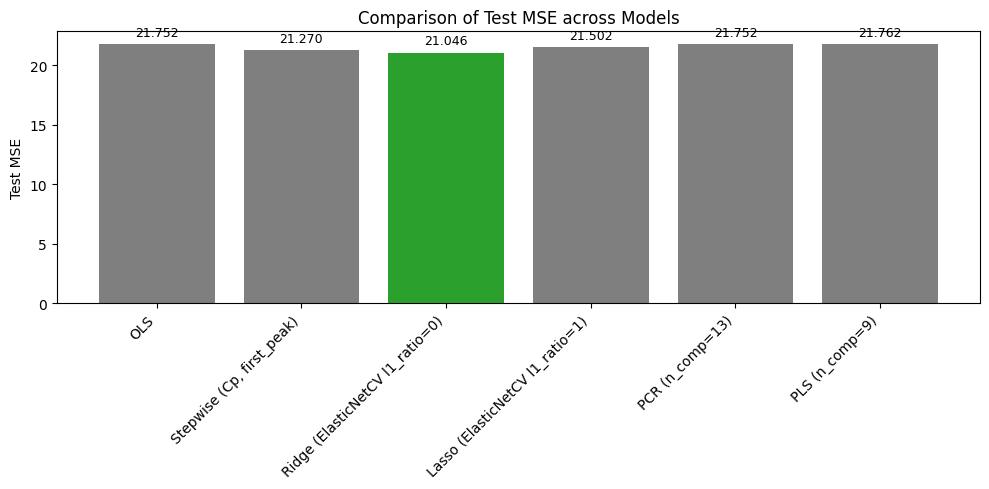

In [12]:
# Evaluate all six models on the same test set (Boston X_test, y_test) and plot comparison
model_objects = {
    "OLS": ols_pipe,
    "Stepwise (Cp, first_peak)": stepwise_model,
    "Ridge (ElasticNetCV l1_ratio=0)": ridge_pipe,
    "Lasso (ElasticNetCV l1_ratio=1)": lasso_pipe,
    f"PCR (n_comp={pcr_ncomp})": best_pcr,
    f"PLS (n_comp={pls_ncomp})": best_pls
}

mse_values = {}
for name, model in model_objects.items():
    if name.startswith("Stepwise"):
        preds = model.predict(X_test[stepwise_vars])
    else:
        preds = model.predict(X_test)
    mse_values[name] = mean_squared_error(y_test, preds)

# Print table-like summary
print("Test MSE for each model:")
for name, mse_val in mse_values.items():
    print(f"  {name}: {mse_val:.6f}")

# Identify best-performing method (lowest test MSE)
best_name = min(mse_values, key=mse_values.get)
best_mse = mse_values[best_name]
print(f"\nBest method based on test MSE: {best_name} (MSE = {best_mse:.6f})")

# Bar chart comparison
names = list(mse_values.keys())
vals = [mse_values[n] for n in names]

# highlight best bar
colors = ["tab:gray"] * len(names)
best_idx = names.index(best_name)
colors[best_idx] = "tab:green"

plt.figure(figsize=(10, 5))
bars = plt.bar(names, vals, color=colors)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Test MSE")
plt.title("Comparison of Test MSE across Models")
# annotate bars
for bar in bars:
    h = bar.get_height()
    plt.annotate(f"{h:.3f}", xy=(bar.get_x() + bar.get_width() / 2, h),
                 xytext=(0, 4), textcoords="offset points", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()